# Tata Steel Machine Failure Prediction - Enhanced EDA

## Project Type
Exploratory Data Analysis + Classification Readiness

## Contribution
Individual
        


## Project Summary
This notebook investigates machine failure behavior in a synthetic yet industry-inspired Tata Steel manufacturing dataset. The goal is to identify reliable early-warning signals for equipment failure so that maintenance teams can act before breakdowns cause production loss.

The data contains product category, thermal conditions, machine speed, torque, tool wear, and failure indicators. EDA focuses on data quality checks, class imbalance understanding, failure-type distribution, feature relationships, and risk-oriented operational insights. Because machine failure is a rare event, a central EDA objective is to identify patterns that can improve minority-class detection in downstream models.

Business value from this analysis includes reduced unplanned downtime, better spare-parts planning, and improved production reliability through proactive maintenance strategies.
        


## Problem Statement
In steel manufacturing, unplanned machine failures increase downtime, maintenance overhead, and quality risk. The business needs an early-warning system that predicts machine failures using operational parameters.

## Business Objective
1. Understand which operational patterns are associated with machine failure.
2. Identify robust features for predictive modeling.
3. Build evidence-backed recommendations for proactive maintenance.
        


In [1]:
# Core libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu

sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', 100)
        


In [2]:
TRAIN_PATH = 'Dataset/train.csv'
TEST_PATH = 'Dataset/test.csv'

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f'Train shape: {train_df.shape}')
print(f'Test shape:  {test_df.shape}')
train_df.head()
        


Train shape: (136429, 14)
Test shape:  (90954, 13)


,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [3]:
# Quick structure and quality checks
print('Train dtypes:')
print(train_df.dtypes)

print('\nMissing values (train):')
print(train_df.isna().sum())

print('\nMissing values (test):')
print(test_df.isna().sum())

print('\nDuplicate rows in train:', train_df.duplicated().sum())
print('Duplicate rows in test:', test_df.duplicated().sum())


Train dtypes:
id                           int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

Missing values (train):
id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Missing values (test):
id            

## Dataset Understanding
Important fields:
- `Type`: Product quality category (`L`, `M`, `H`)
- `Air temperature [K]`, `Process temperature [K]`: Thermal conditions
- `Rotational speed [rpm]`, `Torque [Nm]`, `Tool wear [min]`: Mechanical load and usage
- `Machine failure`: Binary target
- `TWF/HDF/PWF/OSF/RNF`: Specific failure mode indicators (potential leakage risk for real-time prediction)
        


Machine failure
0    134281
1      2148
Name: count, dtype: int64
Failure rate: 1.574%


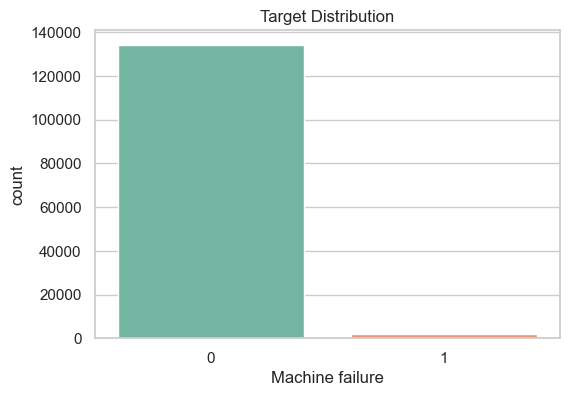

In [4]:
# Target and imbalance
TARGET = 'Machine failure'

target_counts = train_df[TARGET].value_counts().sort_index()
failure_rate = train_df[TARGET].mean() * 100

print(target_counts)
print(f'Failure rate: {failure_rate:.3f}%')

plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x=TARGET, palette='Set2')
plt.title('Target Distribution')
plt.show()
        


### Chart 1 Interpretation
**1. Why did you pick the specific chart?**
A count plot is the clearest way to visualize a binary target and immediately detect class imbalance.

**2. What is/are the insight(s) found from the chart?**
The dataset is highly imbalanced: non-failure cases are 134,281 and failure cases are 2,148 (about 1.57% failure rate).

**3. Will the gained insights help creating a positive business impact? Are there any insights that lead to negative growth? Justify with specific reason.**
Yes. This insight directly informs model strategy: use imbalance-aware metrics (PR-AUC, Recall, F1), class weighting, and threshold tuning. If this imbalance is ignored, the model may show high accuracy but miss real failures, causing unplanned downtime and higher maintenance cost.


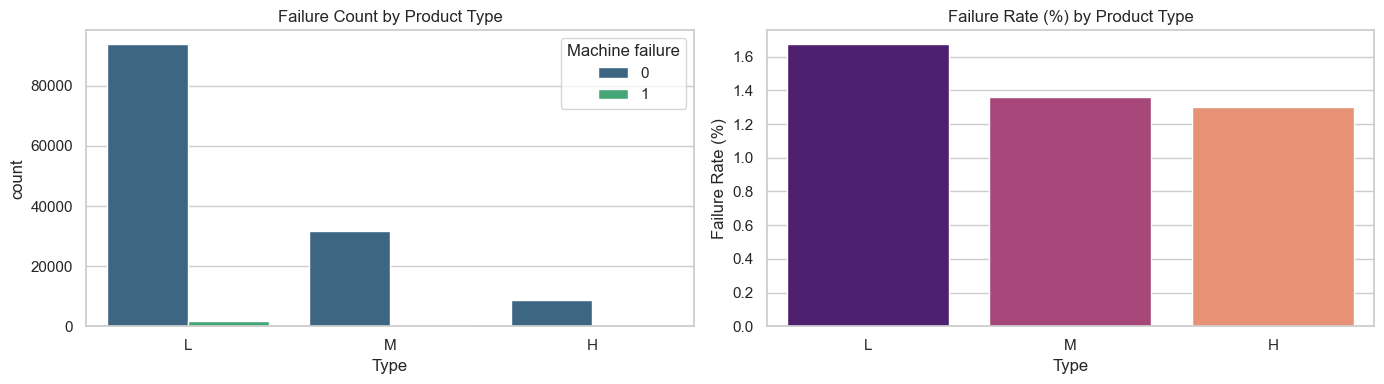

In [5]:
# Failure by product type
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.countplot(data=train_df, x='Type', hue=TARGET, palette='viridis', ax=axes[0])
axes[0].set_title('Failure Count by Product Type')

type_failure_rate = train_df.groupby('Type')[TARGET].mean().sort_values(ascending=False) * 100
sns.barplot(x=type_failure_rate.index, y=type_failure_rate.values, palette='magma', ax=axes[1])
axes[1].set_title('Failure Rate (%) by Product Type')
axes[1].set_ylabel('Failure Rate (%)')

plt.tight_layout()
plt.show()
        


### Chart 2 Interpretation
**1. Why did you pick the specific chart?**
A combined count plot and failure-rate bar chart helps separate production volume effects from true risk effects by product type.

**2. What is/are the insight(s) found from the chart?**
`Type L` has both the largest volume and the highest failure rate (~1.67%), while `Type M` (~1.36%) and `Type H` (~1.30%) are lower.

**3. Will the gained insights help creating a positive business impact? Are there any insights that lead to negative growth? Justify with specific reason.**
Yes. Maintenance planning can prioritize `Type L` operations for inspection and preventive checks. A potential negative impact is overreacting to raw counts alone; decisions should be based on normalized failure rates, otherwise high-volume categories can be unfairly flagged.


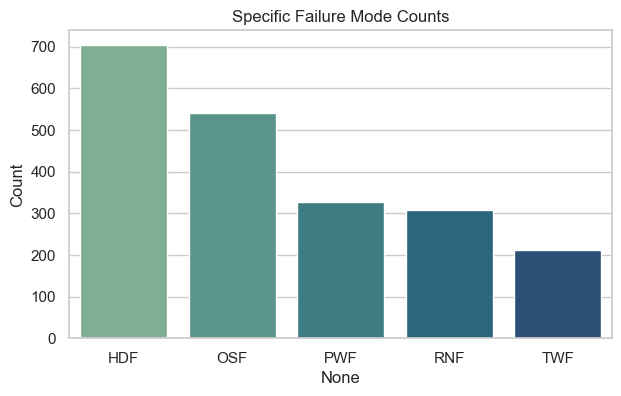

Agreement between (any failure mode) and target: 99.40%
Note: failure-mode flags are highly informative but can leak post-event information in production use-cases.


In [6]:
# Failure mode prevalence and leakage perspective
failure_mode_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
mode_counts = train_df[failure_mode_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(7, 4))
sns.barplot(x=mode_counts.index, y=mode_counts.values, palette='crest')
plt.title('Specific Failure Mode Counts')
plt.ylabel('Count')
plt.show()

or_flag = (train_df[failure_mode_cols].sum(axis=1) > 0).astype(int)
agreement = (or_flag == train_df[TARGET]).mean() * 100
print(f'Agreement between (any failure mode) and target: {agreement:.2f}%')
print('Note: failure-mode flags are highly informative but can leak post-event information in production use-cases.')
        


### Chart 3 Interpretation
**1. Why did you pick the specific chart?**
A bar chart is effective for comparing frequency across multiple failure mode categories.

**2. What is/are the insight(s) found from the chart?**
`HDF` and `OSF` are among the most frequent specific failure modes. Also, the "any failure mode" flag matches the target in about 99.4% of rows, showing very strong association.

**3. Will the gained insights help creating a positive business impact? Are there any insights that lead to negative growth? Justify with specific reason.**
Yes. This helps prioritize root-cause programs (especially thermal dissipation and overstrain controls). Negative impact risk: using these mode flags directly as model inputs can cause data leakage and unrealistic model performance in real-time deployment.


In [7]:
# Feature engineering for richer EDA
eda_df = train_df.copy()
eda_df['Temperature diff [K]'] = eda_df['Process temperature [K]'] - eda_df['Air temperature [K]']
eda_df['Power [kW]'] = (2 * np.pi * eda_df['Rotational speed [rpm]'] * eda_df['Torque [Nm]']) / (60 * 1000)
eda_df['Torque per wear'] = eda_df['Torque [Nm]'] / (eda_df['Tool wear [min]'] + 1)

numeric_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Temperature diff [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Power [kW]',
    'Torque per wear',
]

eda_df[numeric_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
        


,count,mean,std,min,1%,5%,50%,95%,99%,max
Air temperature [K],136429.0,299.862776,1.862247,295.300000,296.400000,297.200000,300.000000,303.000000,303.900000,304.400000
Process temperature [K],136429.0,309.941070,1.385173,305.800000,307.300000,307.800000,310.000000,312.200000,313.100000,313.800000
Temperature diff [K],136429.0,10.078295,0.984934,3.200000,7.800000,8.500000,9.900000,11.500000,11.800000,15.000000
Rotational speed [rpm],136429.0,1520.331110,138.736632,1181.000000,1298.000000,1353.000000,1493.000000,1763.000000,1991.000000,2886.000000
Torque [Nm],136429.0,40.348643,8.502229,3.800000,20.200000,26.300000,40.400000,54.100000,60.500000,76.600000
Tool wear [min],136429.0,104.408901,63.965040,0.000000,0.000000,5.000000,106.000000,202.000000,217.000000,253.000000
Power [kW],136429.0,6.327582,0.998141,0.610474,3.977457,4.750038,6.310203,7.960628,8.794515,16.007064
Torque per wear,136429.0,2.056448,6.845550,0.016814,0.129305,0.169697,0.378218,6.716667,43.200000,68.900000


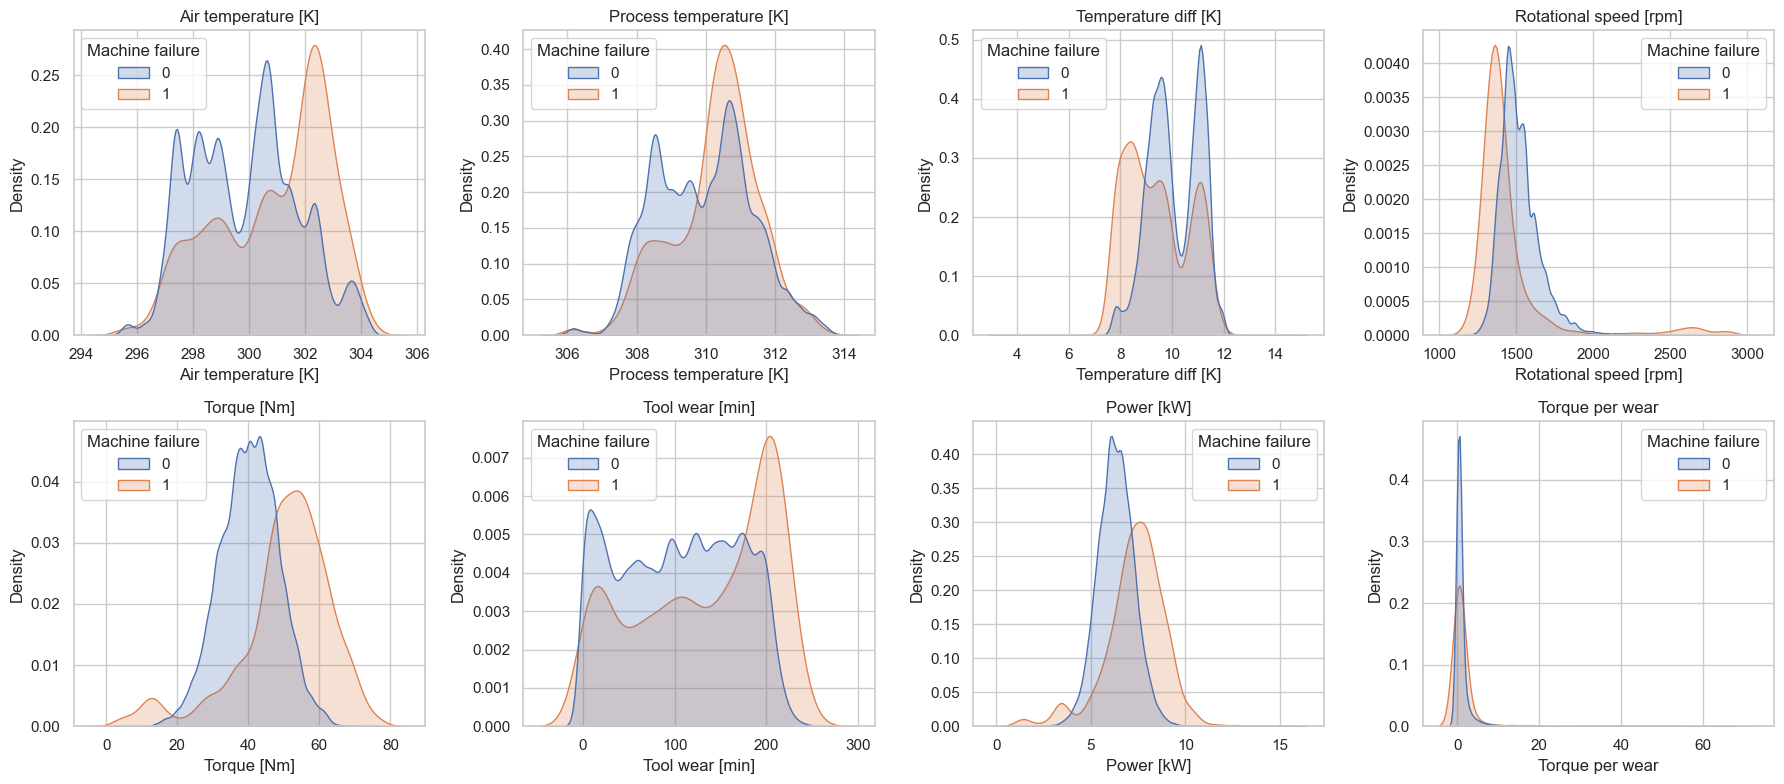

In [8]:
# Distribution comparison by target
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.kdeplot(data=eda_df, x=col, hue=TARGET, common_norm=False, fill=True, alpha=0.25, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()
        


### Chart 4 Interpretation
**1. Why did you pick the specific chart?**
KDE distributions are useful for comparing how full feature distributions shift between failed and non-failed groups.

**2. What is/are the insight(s) found from the chart?**
Failure rows tend to show higher torque (~50 vs ~40 Nm), higher tool wear (~133 vs ~104 min), lower rotational speed (~1454 vs ~1521 rpm), lower temperature difference (~9.42 vs ~10.09 K), and higher power.

**3. Will the gained insights help creating a positive business impact? Are there any insights that lead to negative growth? Justify with specific reason.**
Yes. These shifts support actionable condition-based maintenance triggers and feature engineering for prediction. A possible downside is assuming one hard threshold per feature; because distributions overlap, that can create false alarms or missed failures.


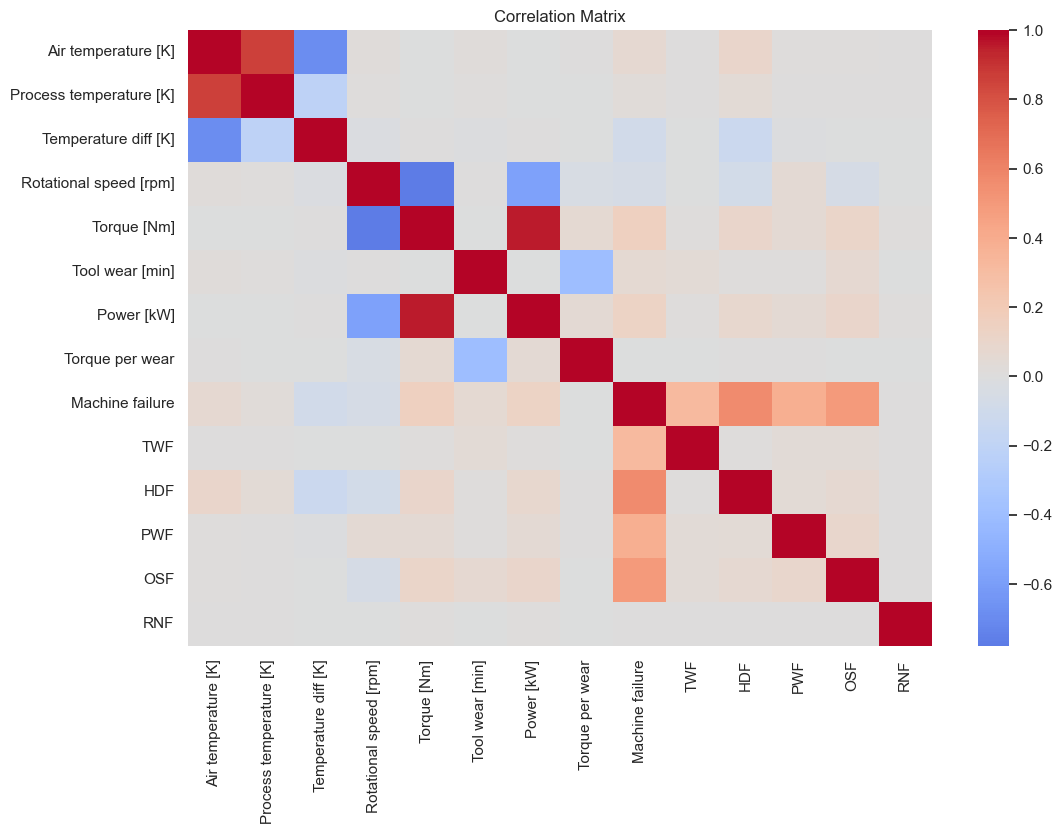

Correlation with target:
Machine failure            1.000000
HDF                        0.564507
OSF                        0.494668
PWF                        0.383941
TWF                        0.311919
Torque [Nm]                0.145793
Power [kW]                 0.128222
Air temperature [K]        0.067744
Tool wear [min]            0.056448
Process temperature [K]    0.030966
RNF                        0.001428
Torque per wear           -0.002422
Rotational speed [rpm]    -0.060868
Temperature diff [K]      -0.084536
Name: Machine failure, dtype: float64


In [9]:
# Correlation heatmap
corr_cols = numeric_cols + [TARGET] + failure_mode_cols
corr = eda_df[corr_cols].corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

corr_target = corr[TARGET].sort_values(ascending=False)
print('Correlation with target:')
print(corr_target)
        


### Chart 5 Interpretation
**1. Why did you pick the specific chart?**
A correlation heatmap gives a compact view of pairwise relationships and helps identify influential or redundant features.

**2. What is/are the insight(s) found from the chart?**
Failure-mode flags have the strongest correlations with target (`HDF` ~0.56, `OSF` ~0.49, `PWF` ~0.38, `TWF` ~0.31). Among operational variables, torque and power are positively related to failure, while rotational speed and temperature difference are negatively related.

**3. Will the gained insights help creating a positive business impact? Are there any insights that lead to negative growth? Justify with specific reason.**
Yes. It guides feature selection and improves explainability for operations teams. Risk: correlation is not causation; if interpreted causally without validation, maintenance actions may target symptoms instead of root causes.


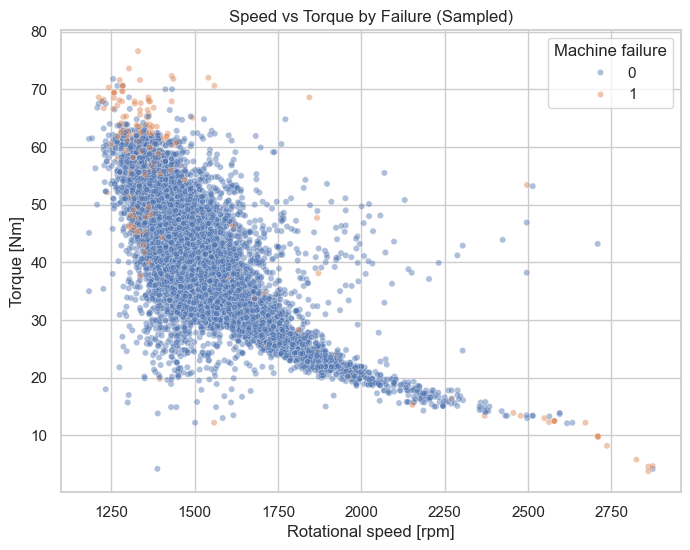

In [10]:
# Bivariate operational map (sampled for readability)
plot_df = eda_df.sample(min(25000, len(eda_df)), random_state=42)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x='Rotational speed [rpm]',
    y='Torque [Nm]',
    hue=TARGET,
    alpha=0.45,
    s=20,
)
plt.title('Speed vs Torque by Failure (Sampled)')
plt.show()
        


### Chart 6 Interpretation
**1. Why did you pick the specific chart?**
A scatter plot captures interaction between speed and torque, which univariate charts cannot show clearly.

**2. What is/are the insight(s) found from the chart?**
Failures cluster more in low-speed, high-torque regions. For example, high-torque + low-speed operating conditions show failure rates around 6.22%, much higher than the overall baseline (~1.57%).

**3. Will the gained insights help creating a positive business impact? Are there any insights that lead to negative growth? Justify with specific reason.**
Yes. This supports multivariate alert rules and safer operating envelopes. Negative risk: relying only on this 2D view can miss failures driven by wear or temperature, so it should be combined with additional signals.


## Hypothesis Testing
We validate statistically whether key operational variables differ between failed and non-failed machines.
        


In [11]:
failed = eda_df[eda_df[TARGET] == 1]
normal = eda_df[eda_df[TARGET] == 0]

# 1) Tool wear difference
stat1, p1 = mannwhitneyu(failed['Tool wear [min]'], normal['Tool wear [min]'], alternative='two-sided')

# 2) Torque difference
stat2, p2 = mannwhitneyu(failed['Torque [Nm]'], normal['Torque [Nm]'], alternative='two-sided')

# 3) Association between Type and target (Chi-square)
cont_table = pd.crosstab(eda_df['Type'], eda_df[TARGET])
chi2, p3, dof, _ = chi2_contingency(cont_table)

hypothesis_results = pd.DataFrame(
    {
        'Test': ['Mann-Whitney (Tool wear)', 'Mann-Whitney (Torque)', 'Chi-square (Type vs Failure)'],
        'p_value': [p1, p2, p3],
        'significant_at_5pct': [p1 < 0.05, p2 < 0.05, p3 < 0.05],
    }
)
hypothesis_results
        


,Test,p_value,significant_at_5pct
0,Mann-Whitney (Tool wear),1.525768e-92,True
1,Mann-Whitney (Torque),0.000000e+00,True
2,Chi-square (Type vs Failure),4.787036e-05,True


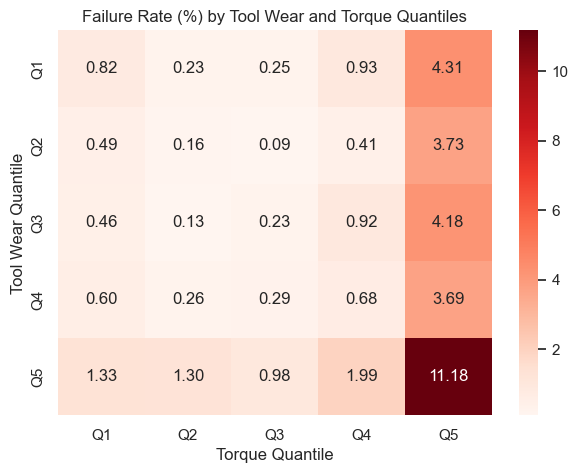

In [12]:
# Risk segmentation table for stakeholder communication
risk_df = eda_df.copy()
risk_df['wear_bin'] = pd.qcut(risk_df['Tool wear [min]'], q=5, labels=['Q1','Q2','Q3','Q4','Q5'])
risk_df['torque_bin'] = pd.qcut(risk_df['Torque [Nm]'], q=5, labels=['Q1','Q2','Q3','Q4','Q5'])

risk_matrix = (
    risk_df
    .groupby(['wear_bin', 'torque_bin'])[TARGET]
    .mean()
    .mul(100)
    .reset_index()
    .pivot(index='wear_bin', columns='torque_bin', values=TARGET)
)

plt.figure(figsize=(7, 5))
sns.heatmap(risk_matrix, annot=True, fmt='.2f', cmap='Reds')
plt.title('Failure Rate (%) by Tool Wear and Torque Quantiles')
plt.ylabel('Tool Wear Quantile')
plt.xlabel('Torque Quantile')
plt.show()
        


### Chart 7 Interpretation
**1. Why did you pick the specific chart?**
A heatmap over wear and torque quantiles converts continuous variables into an easy risk segmentation matrix for operations.

**2. What is/are the insight(s) found from the chart?**
Failure risk increases strongly toward high wear and high torque bins. In this dataset, risk ranges from about 0.09% in low-risk bins to about 11.18% in the highest wear/highest torque segment.

**3. Will the gained insights help creating a positive business impact? Are there any insights that lead to negative growth? Justify with specific reason.**
Yes. This is directly usable for maintenance prioritization, spare-part planning, and shift-level risk monitoring. Potential downside: quantile-based bins are data-dependent; if plant behavior drifts over time and bins are not recalibrated, alert quality can degrade.


## Key EDA Insights
1. The target is strongly imbalanced (~1.57% failures), requiring imbalance-aware evaluation metrics.
2. Higher tool wear and high-load conditions (torque/speed combinations) are associated with elevated failure risk.
3. Failure mode flags are near-direct proxies of target in this dataset and can cause leakage for real-time prediction if used naively.
4. Product type has statistically significant association with failure behavior.
5. Engineered features such as temperature difference and power create better physical interpretability for maintenance teams.
        


## Business Impact and Stakeholder Usefulness
- **Maintenance Team:** Prioritize preventive checks for high wear-high torque zones.
- **Production Planning:** Use risk scores to schedule maintenance during low-impact windows.
- **Quality Team:** Monitor product type-specific risk trends to reduce defect propagation.
- **Plant Leadership:** Track recall-focused model KPIs to reduce unplanned downtime and maintenance cost.

This EDA directly informs model design, threshold strategy, and operational alerting policy.
        


## Conclusion
The dataset is modeling-ready and contains meaningful predictive signals for machine failure. Because failures are rare, downstream modeling should prioritize recall/PR-AUC over raw accuracy and should carefully manage leakage-prone columns. A predictive maintenance workflow built on these insights can significantly improve operational reliability for Tata Steel.
        
